# 2026 The Best Ski Trip Prediction

In [154]:
import pandas as pd
import numpy as np
from pathlib import Path

## Data Parsing and Cleaning

In [155]:
# Read the excel data
data_fp = list(Path().rglob('../data/2025*.xlsx'))[0]
excel_sheets = pd.read_excel(data_fp, sheet_name=None)
# Unpack the excel sheets
info_data, visitation_data, climate_data = [v for _, v in excel_sheets.items()]

### Parsing the info sheet 
1. Station ID and location
2. Winter ski weeks and dates

In [176]:
climate_data_clean.station_id.unique()

array(['71075', '71032', '83024', '83084', '83085', '85291', '72161'],
      dtype=object)

In [186]:
location_id = info_data.iloc[21:26,1].copy()
location_id = pd.DataFrame(location_id.str.split(" - ").to_list(), columns=["station_id", "location"])

st_id = ['83085', '85291', '83024']
loc = ['Mt. Hotham', 'Mt. Baw Baw', 'Mt. Stirling']
addtl_locations = pd.DataFrame([{"station_id": station_id, "location": resort} for station_id, resort in zip(st_id, loc)])

location_id = pd.concat([location_id, addtl_locations])
location_id["location"] = location_id.location.str.replace(" AWS", "").str.replace("Mount", "Mt.")
location_id.loc[location_id.station_id=="72161", "location"] = "Selwyn"

location_id = location_id.astype({"station_id": str})

print(location_id.info())

location_id

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 0 to 2
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   station_id  8 non-null      object
 1   location    8 non-null      object
dtypes: object(2)
memory usage: 192.0+ bytes
None


,station_id,location
0,71032,Thredbo
1,71075,Perisher
2,72161,Selwyn
3,83024,Mt. Buller
4,83084,Falls Creek
0,83085,Mt. Hotham
1,85291,Mt. Baw Baw
2,83024,Mt. Stirling


In [157]:
ski_season_dates = (info_data.iloc[35:, 1:].copy()
                    .rename(columns={"Unnamed: 1": "week", "Unnamed: 2": "dates"})
                    .reset_index(drop=True))
ski_season_dates["dates"] = ski_season_dates["dates"].dt.strftime("%d-%b")

print(ski_season_dates.info())

# Check the weeks
ski_season_dates.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   week    15 non-null     object
 1   dates   15 non-null     object
dtypes: object(2)
memory usage: 372.0+ bytes
None


,week,dates
0,Week 1,09-Jun
1,Week 2,16-Jun
2,Week 3,23-Jun
3,Week 4,30-Jun
4,Week 5,07-Jul


### Parsing the climate data

In [158]:
# Check unclean data
climate_data.tail()

,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres)
39808,72161,2025,7,24,3.0,-2.7,4.2
39809,72161,2025,7,25,6.0,-2.4,0.2
39810,72161,2025,7,26,2.7,0.0,10.2
39811,72161,2025,7,27,2.5,1.3,15.6
39812,72161,2025,7,28,2.2,-0.1,54.4


In [159]:
# Renaming columns using dictionary
cd_col_names = [col.lower() for col in climate_data.columns]
cd_col_names[0] = "station_id"
cd_col_names[-3:] = ["max_temp_c", "min_temp_c", "rainfall_mm"]
cd_col_names = {col_old: col_new for col_old, col_new in zip(climate_data.columns, cd_col_names)}
climate_data_clean = climate_data.copy().rename(columns=cd_col_names)

# Type formatting
climate_data_clean = climate_data_clean.astype({"station_id": str, "year": str})

# Check datatype
print(climate_data_clean.info())

# Check records
climate_data_clean.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39813 entries, 0 to 39812
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   station_id   39813 non-null  object 
 1   year         39813 non-null  object 
 2   month        39813 non-null  int64  
 3   day          39813 non-null  int64  
 4   max_temp_c   38275 non-null  float64
 5   min_temp_c   38280 non-null  float64
 6   rainfall_mm  37857 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 2.1+ MB
None


,station_id,year,month,day,max_temp_c,min_temp_c,rainfall_mm
39808,72161,2025,7,24,3.0,-2.7,4.2
39809,72161,2025,7,25,6.0,-2.4,0.2
39810,72161,2025,7,26,2.7,0.0,10.2
39811,72161,2025,7,27,2.5,1.3,15.6
39812,72161,2025,7,28,2.2,-0.1,54.4


### Parsing the visitation data

In [160]:
# Converting to long format for easier processing
visitation_data_long = (visitation_data.copy()
                        .melt(id_vars=("Year", "Week"), var_name="location", value_name="visitors")
                        .rename(columns={"Year" : "year", "Week" : "week"}))
visitation_data_long = visitation_data_long.astype({"year": str, "week": str})
visitation_data_long.head()

,year,week,location,visitors
0,2014,1,Mt. Baw Baw,555
1,2014,2,Mt. Baw Baw,804
2,2014,3,Mt. Baw Baw,993
3,2014,4,Mt. Baw Baw,2976
4,2014,5,Mt. Baw Baw,11112


In [161]:
visitation_data_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1485 entries, 0 to 1484
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   year      1485 non-null   object
 1   week      1485 non-null   object
 2   location  1485 non-null   object
 3   visitors  1485 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 46.5+ KB


## Exporting the data

In [162]:
location_id.to_csv(data_fp.parent / "location_id.csv", index=False)
location_id.to_parquet(data_fp.parent / "location_id.parquet", engine="fastparquet")

In [163]:
ski_season_dates.to_csv(data_fp.parent / "ski_season_dates.csv", index=False)
ski_season_dates.to_parquet(data_fp.parent / "ski_season_dates.parquet", engine="fastparquet")

In [164]:
climate_data_clean.to_csv(data_fp.parent / "climate_data.csv", index=False)
climate_data_clean.to_parquet(data_fp.parent / "climate_data.parquet", engine="fastparquet")

In [165]:
visitation_data.to_csv(data_fp.parent / "visitation_data_raw.csv", index=False)
visitation_data_long.to_csv(data_fp.parent / "visitation_data_long.csv", index=False)
visitation_data_long.to_parquet(data_fp.parent / "visitation_data_long.parquet", engine="fastparquet")

## Merging the tables

In [167]:
import pandas as pd
from pathlib import Path

# Build the ski-season calendar (Weeks 1–15) for every year we have in visitation
ski_mmdd = ["06-09","06-16","06-23","06-30","07-07","07-14","07-21","07-28",
            "08-04","08-11","08-18","08-25","09-01","09-08","09-15"]

def ski_calendar_for_year(y: int) -> pd.DataFrame:
    starts = pd.to_datetime([f"{y}-{md}" for md in ski_mmdd])
    cal = pd.DataFrame({"Year": y, "Week": range(1, 16), "Start": starts})
    cal["End"] = cal["Start"] + pd.Timedelta(days=7)
    return cal

years = sorted(visitation_data["Year"].unique())
ski_cal = pd.concat([ski_calendar_for_year(y) for y in years], ignore_index=True)

# Turn daily climate into ski-week climate
cl = climate_data.copy()
cl["Date"] = pd.to_datetime(dict(year=cl["Year"], month=cl["Month"], day=cl["Day"]), errors="coerce")
cl = cl.dropna(subset=["Date"]).sort_values(["Year","Date"]).reset_index(drop=True)

def tag_skiweek(df_year: pd.DataFrame) -> pd.DataFrame:
    # For each date, find the most recent ski-week start within the last 6 days
    cal = (ski_cal[ski_cal["Year"] == int(df_year["Year"].iloc[0])]
           [["Start","Week"]].sort_values("Start"))
    out = pd.merge_asof(
        df_year.sort_values("Date"),
        cal.rename(columns={"Start": "StartDate"}).sort_values("StartDate"),
        left_on="Date", right_on="StartDate",
        direction="backward", tolerance=pd.Timedelta(days=6)
    )
    return out

cl_tagged = pd.concat([tag_skiweek(g) for _, g in cl.groupby("Year")], ignore_index=True)
cl_tagged = cl_tagged.merge(ski_cal[["Year","Week","Start","End"]], on=["Year","Week"], how="left")
# Keep rows that truly fall inside a ski week window
cl_tagged = cl_tagged[(cl_tagged["Week"].notna()) & (cl_tagged["Date"] < cl_tagged["End"])].copy()
cl_tagged["Week"] = cl_tagged["Week"].astype(int)

# Aggregate to (Year, Week): temps = mean, rainfall = sum
weekly_climate = (
    cl_tagged.groupby(["Year","Week"], as_index=False)
    .agg({
        "Maximum temperature (Degree C)": "mean",
        "Minimum temperature (Degree C)": "mean",
        "Rainfall amount (millimetres)": "sum"
    })
)

# Clean visitation numbers
vis = visitation_data.copy()
for c in vis.columns:
    if c not in ["Year","Week"]:
        vis[c] = pd.to_numeric(vis[c], errors="coerce").fillna(0).clip(lower=0)

# Long format: one row per (Year, Week, Resort)
resort_cols = [c for c in vis.columns if c not in ["Year","Week"]]
vis_long = vis.melt(id_vars=["Year","Week"], value_vars=resort_cols,
                    var_name="Resort", value_name="Visitors")

# Add state for each resort
state_map = {
    "Mt. Stirling": "VIC",
    "Mt. Buller": "VIC",
    "Mt. Baw Baw": "VIC",
    "Mt. Hotham": "VIC",
    "Falls Creek": "VIC",
    "Selwyn": "NSW",
    "Thredbo": "NSW",
    "Perisher": "NSW",
    # Charlotte Pass will be created below and set to NSW
}
vis_long["State"] = vis_long["Resort"].map(state_map)

# Create Charlotte Pass (NSW) as the average of Perisher and Thredbo for each (Year, Week)
pt = vis_long[vis_long["Resort"].isin(["Perisher","Thredbo"])].pivot_table(
    index=["Year","Week"], columns="Resort", values="Visitors", aggfunc="mean"
).reset_index()

if {"Perisher","Thredbo"}.issubset(pt.columns):
    char = pd.DataFrame({
        "Year": pt["Year"],
        "Week": pt["Week"],
        "Resort": "Charlotte Pass",
        "Visitors": (pt["Perisher"] + pt["Thredbo"]) / 2.0,
        "State": "NSW"
    })
    vis_long = pd.concat([vis_long, char], ignore_index=True)

# Keep only ski-season weeks (1..15) to match the calendar
vis_long = vis_long[vis_long["Week"].between(1, 15)].reset_index(drop=True)

# Attach the weekly climate to every resort row
merged_data = vis_long.merge(weekly_climate, on=["Year","Week"], how="left")

# Save to data/merged_data.csv
out_path = Path("../data") / "merged/merged_data.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
merged_data.to_csv(out_path, index=False)

print(f"Saved merged long-format data to {out_path.resolve()}")

# # Rename
# old_colnames = [col for col in merged_data.columns]
# new_colnames = [col.lower() for col in old_colnames[0:5]] + ["max_temp_c", "min_temp_c", "rainfall_mm"]

# merged_data = merged_data.rename(columns={old_col:new_col for old_col, new_col in zip(old_colnames, new_colnames)})

merged_data.head()

Saved merged long-format data to /Users/rapcanlas/Desktop/R2B2Datathon2025/R2B2/data/merged/merged_data.csv


,Year,Week,Resort,Visitors,State,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres)
0,2014,1,Mt. Baw Baw,555.0,VIC,5.022449,-0.338776,236.2
1,2014,2,Mt. Baw Baw,804.0,VIC,4.683673,-0.440816,125.4
2,2014,3,Mt. Baw Baw,993.0,VIC,0.308163,-2.553061,634.2
3,2014,4,Mt. Baw Baw,2976.0,VIC,1.236735,-2.363265,301.2
4,2014,5,Mt. Baw Baw,11112.0,VIC,-0.200000,-3.516327,257.0


C:\Users\Suman\AppData\Local\Temp\ipykernel_16532\1520001872.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x="Year", y="Visitors", data=df, estimator="sum", ci=None)


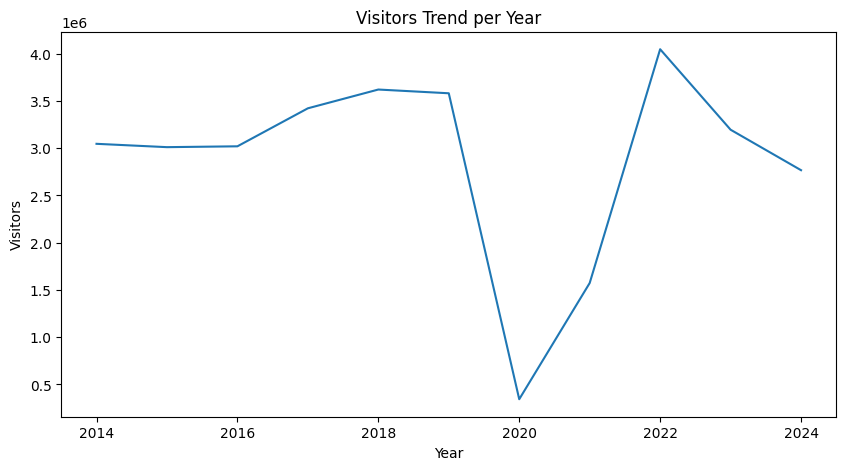

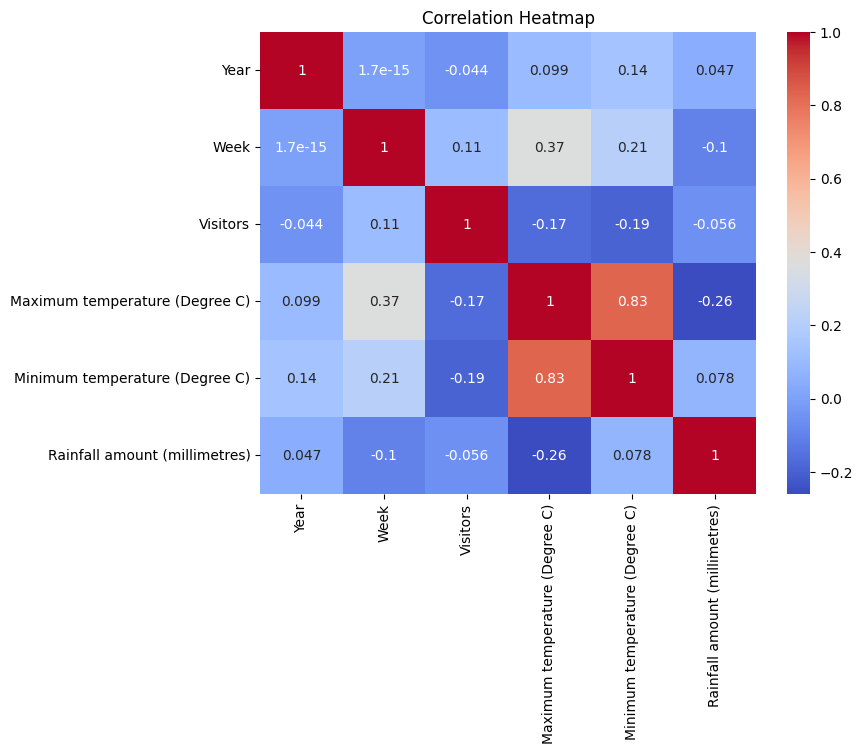

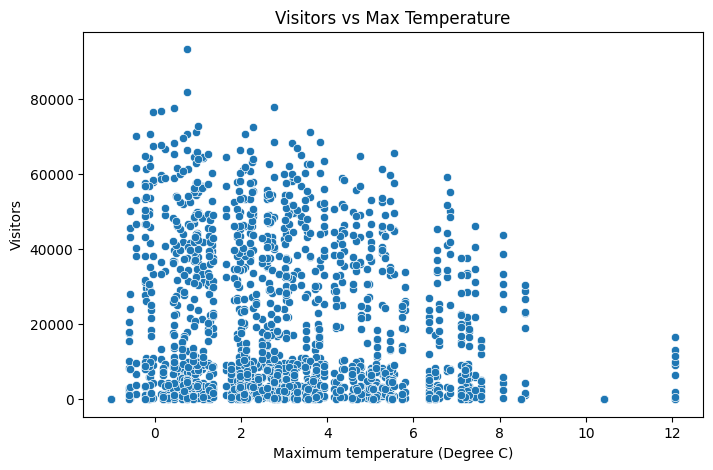

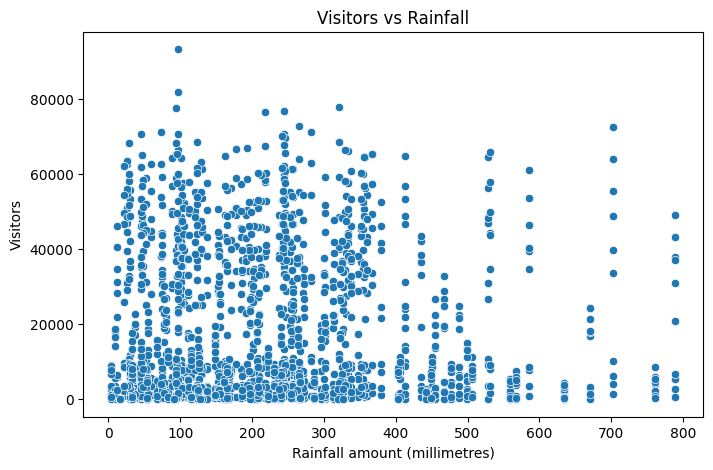

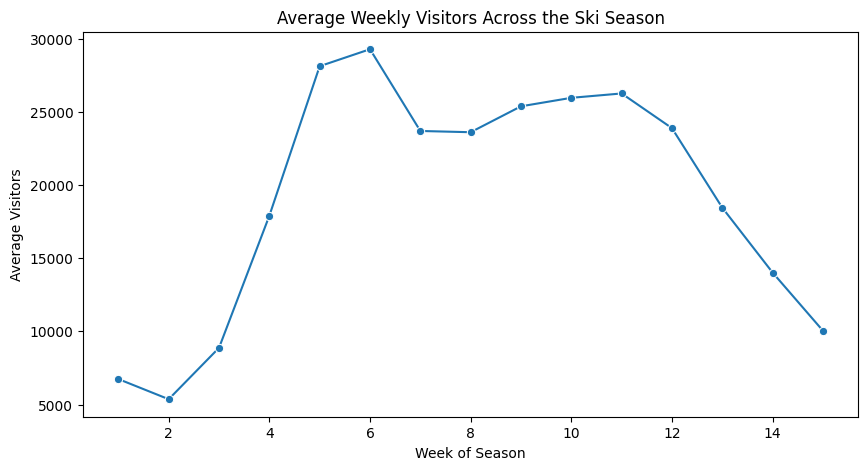

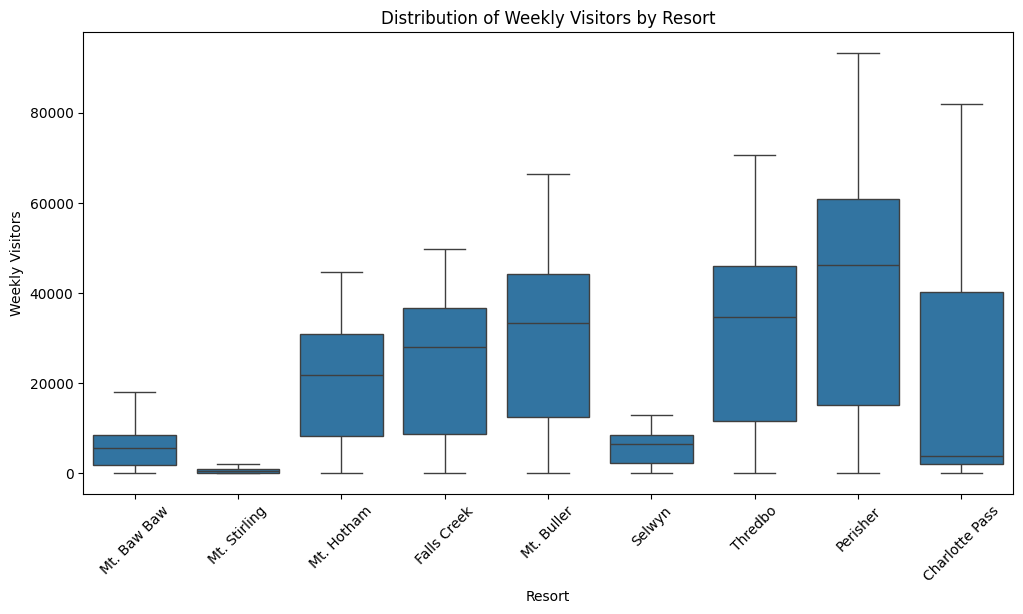

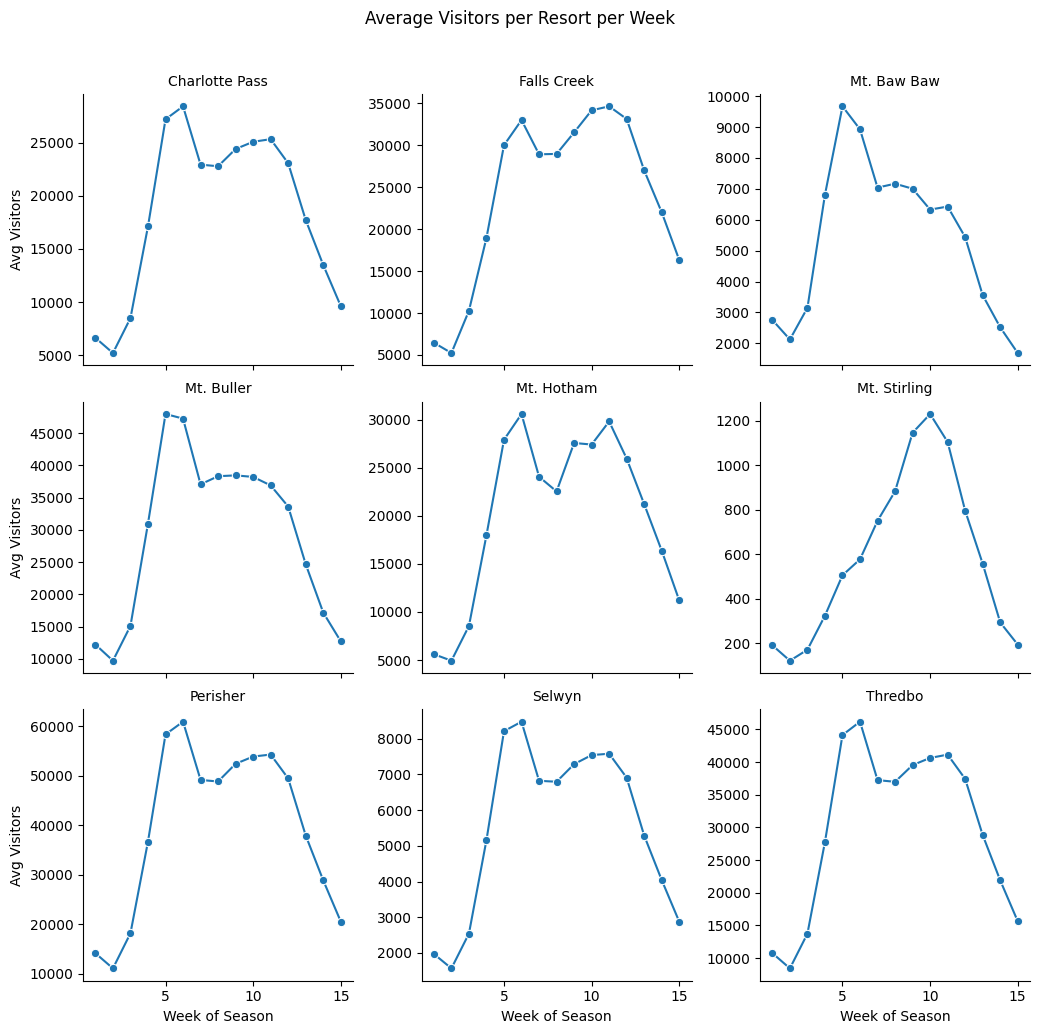

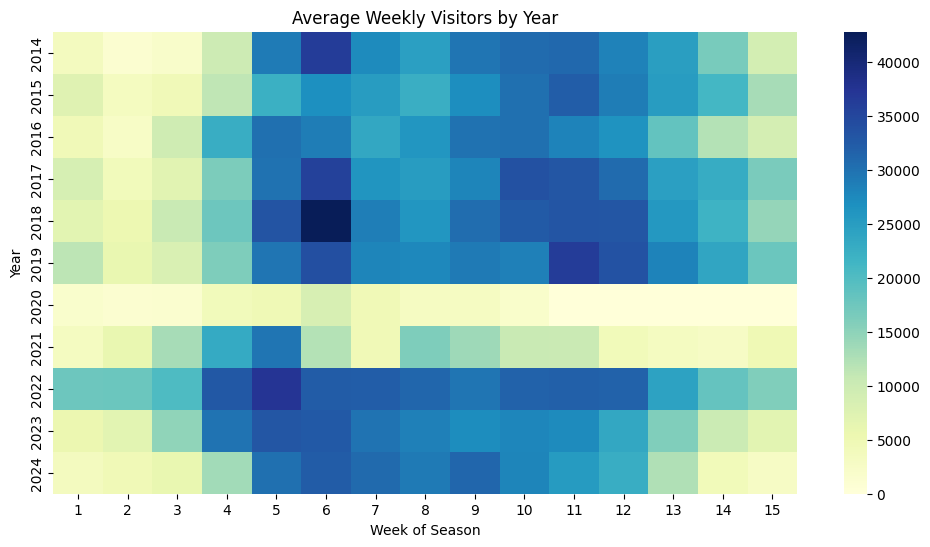

C:\Users\Suman\AppData\Local\Temp\ipykernel_16532\1520001872.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  phase_visitors = df.groupby(["Resort","SeasonPhase"])["Visitors"].mean().reset_index()


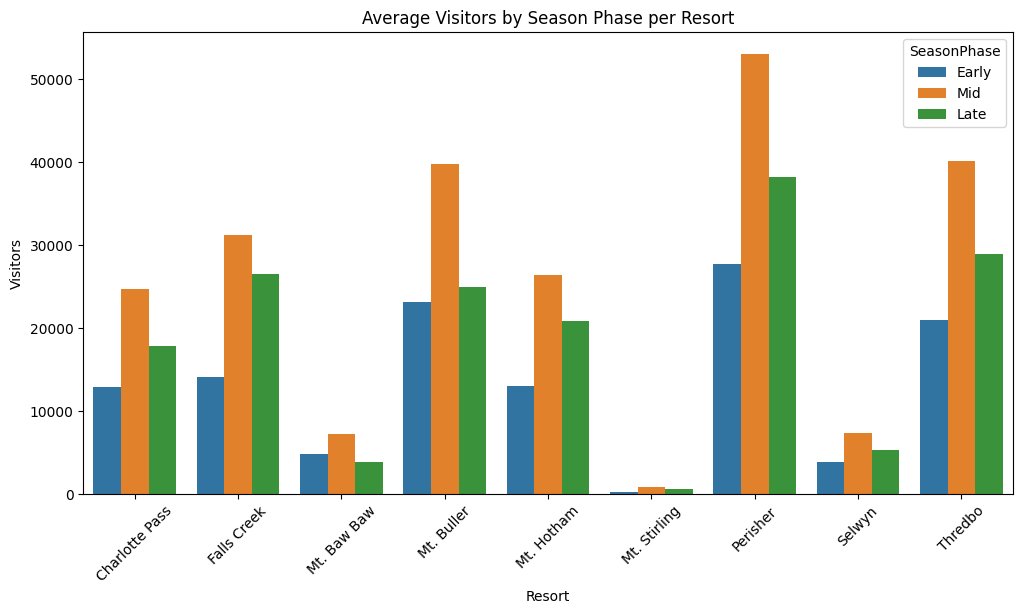

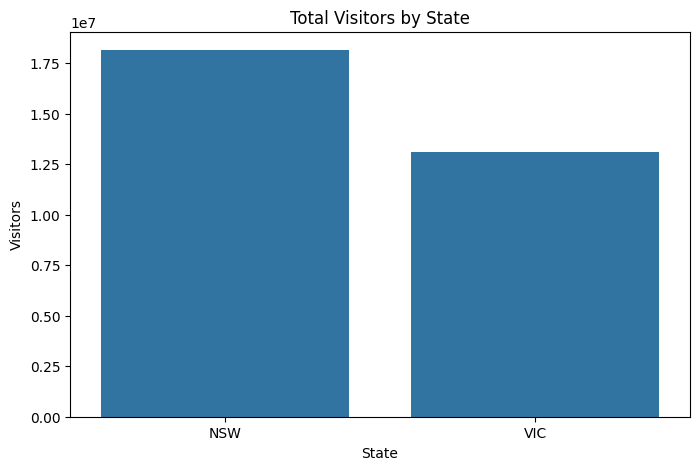

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("C:\\Users\\Suman\\Downloads\\R2B2-1\\data\\merged\\merged_data.csv")


# Visitors per Year
plt.figure(figsize=(10,5))
sns.lineplot(x="Year", y="Visitors", data=df, estimator="sum", ci=None)
plt.title("Visitors Trend per Year")
plt.show()

# -----------------------------
# 5. Correlation Analysis
# -----------------------------
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# -----------------------------
# 6. Weather Impact on Visitors
# -----------------------------
plt.figure(figsize=(8,5))
sns.scatterplot(x="Maximum temperature (Degree C)", y="Visitors", data=df)
plt.title("Visitors vs Max Temperature")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(x="Rainfall amount (millimetres)", y="Visitors", data=df)
plt.title("Visitors vs Rainfall")
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Average weekly visitors across the ski season
avg_weekly = df.groupby("Week")["Visitors"].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(x="Week", y="Visitors", data=avg_weekly, marker="o")
plt.title("Average Weekly Visitors Across the Ski Season")
plt.xlabel("Week of Season")
plt.ylabel("Average Visitors")
plt.show()


# 2. Distribution of weekly visitors by resort
plt.figure(figsize=(12,6))
sns.boxplot(x="Resort", y="Visitors", data=df)
plt.title("Distribution of Weekly Visitors by Resort")
plt.xticks(rotation=45)
plt.ylabel("Weekly Visitors")
plt.show()


g = sns.FacetGrid(avg_resort_week, col="Resort", col_wrap=3, height=3.5, sharey=False)
g.map_dataframe(sns.lineplot, x="Week", y="Visitors", marker="o")
g.set_titles("{col_name}")
g.set_axis_labels("Week of Season", "Avg Visitors")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Average Visitors per Resort per Week")
plt.show()

pivot_visitors = df.pivot_table(values="Visitors", index="Year", columns="Week", aggfunc="mean")

plt.figure(figsize=(12,6))
sns.heatmap(pivot_visitors, cmap="YlGnBu", annot=False)
plt.title("Average Weekly Visitors by Year")
plt.xlabel("Week of Season")
plt.ylabel("Year")
plt.show()

df["SeasonPhase"] = pd.cut(df["Week"], bins=[0,5,10,15], labels=["Early","Mid","Late"])

phase_visitors = df.groupby(["Resort","SeasonPhase"])["Visitors"].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x="Resort", y="Visitors", hue="SeasonPhase", data=phase_visitors)
plt.title("Average Visitors by Season Phase per Resort")
plt.xticks(rotation=45)
plt.show()


state_visitors = df.groupby("State")["Visitors"].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x="State", y="Visitors", data=state_visitors)
plt.title("Total Visitors by State")
plt.show()



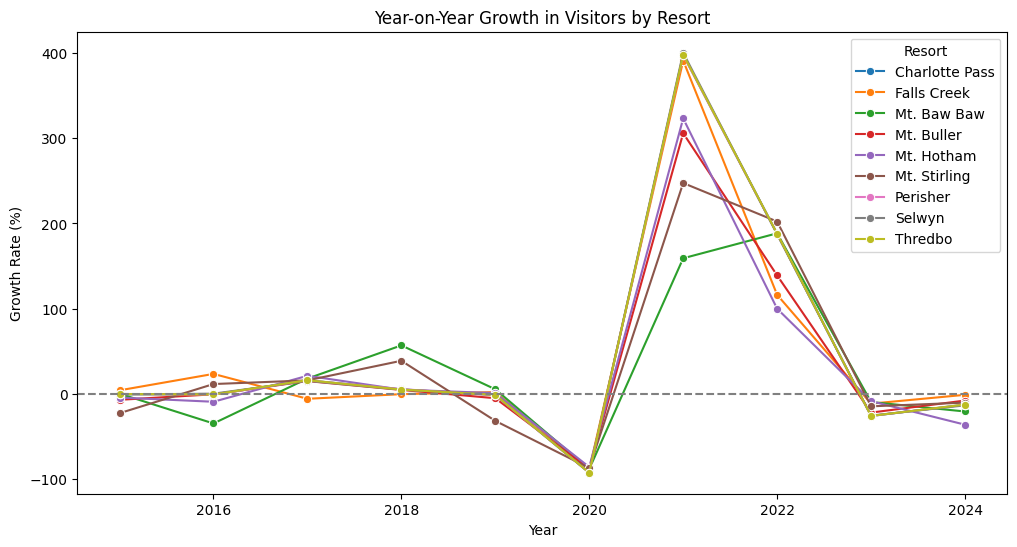

C:\Users\Suman\AppData\Local\Temp\ipykernel_16532\1649419084.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_visitors = df.groupby("Temp_bin")["Visitors"].mean().reset_index()


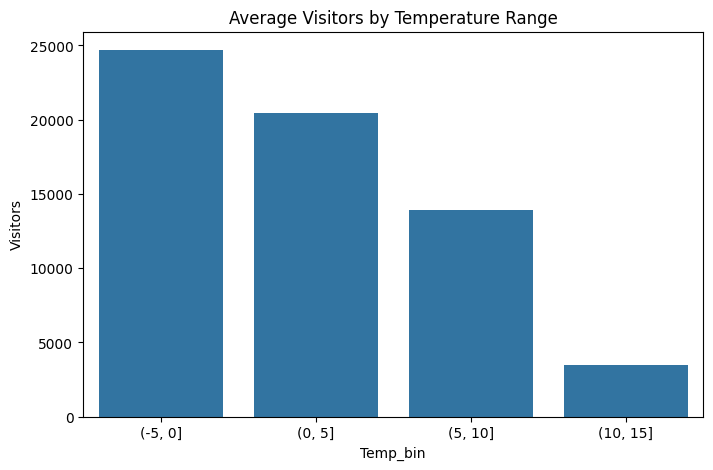

Best overall week is Week 6.0 with 3220117 visitors


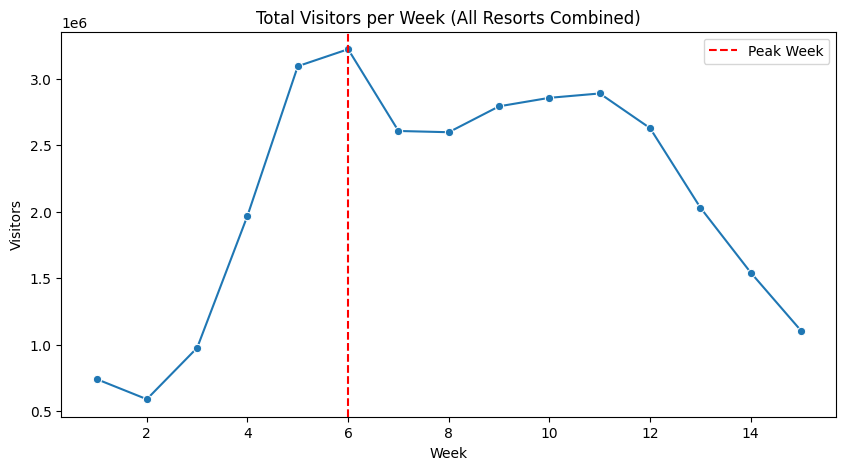

In [ ]:
growth = df.groupby(["Year","Resort"])["Visitors"].sum().reset_index()
growth["YoY_Growth"] = growth.groupby("Resort")["Visitors"].pct_change() * 100

plt.figure(figsize=(12,6))
sns.lineplot(x="Year", y="YoY_Growth", hue="Resort", data=growth, marker="o")
plt.title("Year-on-Year Growth in Visitors by Resort")
plt.ylabel("Growth Rate (%)")
plt.axhline(0, color="gray", linestyle="--")
plt.show()

df["Temp_bin"] = pd.cut(df["Maximum temperature (Degree C)"], bins=[-5,0,5,10,15])
temp_visitors = df.groupby("Temp_bin")["Visitors"].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x="Temp_bin", y="Visitors", data=temp_visitors)
plt.title("Average Visitors by Temperature Range")
plt.show()


weekly_sum = df.groupby("Week")["Visitors"].sum().reset_index()
best_week = weekly_sum.loc[weekly_sum["Visitors"].idxmax()]
print("Best overall week is Week", best_week["Week"], "with", int(best_week["Visitors"]), "visitors")

plt.figure(figsize=(10,5))
sns.lineplot(x="Week", y="Visitors", data=weekly_sum, marker="o")
plt.axvline(best_week["Week"], color="red", linestyle="--", label="Peak Week")
plt.title("Total Visitors per Week (All Resorts Combined)")
plt.legend()
plt.show()





## 2025 Data

In [328]:
# Get data for 2025 only
climate_data_2025 = climate_data[climate_data.Year==2025].rename(columns={"Bureau of Meteorology station number": "station_id"})
climate_data_2025["station_id"] = climate_data_2025["station_id"].astype(str)
climate_data_2025["Date"] = (climate_data_2025.apply(lambda rec: f"{int(rec.Day):02d}-{int(rec.Month):02d}-{int(rec.Year)}", axis=1))
climate_data_2025["Date"] = pd.to_datetime(climate_data_2025["Date"], format="%d-%m-%Y")

# Convert date to week for 2025 data
ski_dates_2025 = pd.to_datetime(ski_season_dates.dates + '-2025', format="%d-%b-%Y")
ski_weeks_2025 = pd.DataFrame({"Year": np.repeat(2025, len(ski_dates_2025)), 
               "Week": np.arange(1,len(ski_dates_2025) + 1), 
               "Start": ski_dates_2025,
               "End": ski_dates_2025 + pd.Timedelta(days=6)
               })

# Map the weeks based on the date ranges
intervals = pd.IntervalIndex.from_arrays(ski_weeks_2025.Start, ski_weeks_2025.End, closed="both")
week_labels = [str(i) for i in np.arange(1,16)]
climate_data_2025["Week"] = pd.cut(climate_data_2025.Date, bins=intervals).map(dict(zip(intervals, week_labels)))

# Get resorts and states
resort_state = merged_data[["Resort", "State"]].drop_duplicates()

# Add Resort name and state
climate_data_2025 = (pd.merge(climate_data_2025, location_id, on="station_id")
                     .rename(columns={"location": "Resort"}))

# Drop unnecessary columns
climate_data_2025 = climate_data_2025.drop(columns=["station_id", "Month", "Day", "Date"])


# Drop all NAN before aggregation
climate_data_2025 = climate_data_2025.dropna(subset=["Week", "Maximum temperature (Degree C)", "Minimum temperature (Degree C)", "Rainfall amount (millimetres)"])

# Get aggregate date
climate_data_2025 = (climate_data_2025.groupby(["Year", "Week", "Resort"]).agg({
    "Maximum temperature (Degree C)": "mean", 
    "Minimum temperature (Degree C)": "mean", 
    "Rainfall amount (millimetres)": "sum"}).reset_index())

# Remove all NAN from final
climate_data_2025 = climate_data_2025.dropna(subset=["Week", "Maximum temperature (Degree C)", "Minimum temperature (Degree C)", "Rainfall amount (millimetres)"])

# Add State based on location
climate_data_2025 = pd.merge(climate_data_2025, resort_state, on="Resort")

# Rearrange same way as merged_data
climate_data_2025 = climate_data_2025[["Year", 
                                       "Week", 
                                       "Resort", 
                                       "State", 
                                       "Maximum temperature (Degree C)", 
                                       "Minimum temperature (Degree C)", 
                                       "Rainfall amount (millimetres)"
                                       ]]

climate_data_2025.tail()

/var/folders/_t/r5trfwf935jfhb767r0mq93m0000gn/T/ipykernel_81169/2863956382.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  climate_data_2025 = (climate_data_2025.groupby(["Year", "Week", "Resort"]).agg({


,Year,Week,Resort,State,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres)
58,2025,8,Mt. Buller,VIC,0.3,-1.2,38.0
59,2025,8,Mt. Hotham,VIC,-0.1,-1.7,32.8
60,2025,8,Mt. Stirling,VIC,0.3,-1.2,38.0
61,2025,8,Perisher,NSW,0.9,-1.1,49.0
62,2025,8,Selwyn,NSW,2.2,-0.1,54.4


In [329]:
climate_data_2025.describe()

,Year,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres)
count,63.0,63.000000,63.000000,63.000000
mean,2025.0,1.608367,-2.415930,35.888889
std,0.0,1.879638,1.540151,33.042158
min,2025.0,-1.957143,-6.100000,0.000000
25%,2025.0,0.404762,-3.498810,10.200000
50%,2025.0,1.285714,-2.442857,22.600000
75%,2025.0,2.357143,-1.200000,51.800000
max,2025.0,6.742857,1.014286,148.600000


In [327]:
merged_data.describe()

,Year,Week,Visitors,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres)
count,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000
mean,2019.000000,8.000000,19167.435152,3.087014,-2.053558,232.547879
std,3.163236,4.321804,19962.004864,2.359077,1.732000,160.306403
min,2014.000000,1.000000,0.000000,-1.011905,-5.904082,4.200000
25%,2016.000000,4.000000,2662.000000,1.223256,-3.209756,105.600000
50%,2019.000000,8.000000,9095.500000,2.722449,-2.230612,209.400000
75%,2022.000000,12.000000,34692.500000,4.663265,-1.097917,324.600000
max,2024.000000,15.000000,93226.000000,12.068571,5.811429,788.800000


In [326]:
# Exporting the 2025 data
climate_data_2025.to_csv(data_fp.parent / "climate_data_2025.csv", index=False)
climate_data_2025.to_parquet(data_fp.parent / "climate_data_2025.parquet", engine="fastparquet")